Backgammon : An Atari Environment
https://ale.farama.org/environments/backgammon/

Agent: PPO

Goal: To move all pieces off the board for either the RED or WHITE Player


*   Action Space:      Discrete(0: FIRE, 1:RIGHT, 2: LEFT)
*   Actions:           18 possible Actions
*   Observation Space: Box(0, 255, (210, 160, 3) uint8)
*   Environment Import: gymnasium.make("ALEBackgammon-v5")
*   Observation Type:   rgb, grayscale, ram
*   Variants:           v5 or ram-v5
*   Difficulty          3 choices

Version History:
*

In [3]:
from google.colab import drive
drive.mount("content/drive")

ValueError: Mountpoint must be in a directory that exists

Required Installations

In [12]:
# TO be run once per Google Colab session
!apt update
!apt-get install xvfb x11-utils
!apt-get install -y xvfb
!python -m pip install gymnasium[atari]
!python -m pip install pyvirtualdisplay
!python -m pip install -- upgrade swig
!python -m pip install --upgrade pyvirtualdisplay moviepy
!python -m pip install --upgrade gymnasium[accept-rom-license,atari,box2d,classic_control,mujoco,toy_text]
!python -m pip install torchinfo
!python -m pip install torch
from torch.utils.data import Dataset
!pip install box2d-py==2.3.5

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
49 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as

Importation of Libraries

In [52]:
# import necessary libraries
import os
os.environ['XDG_RUNTIME_DIR'] = '/tmp/runtime-tristan'
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from gymnasium.vector import SyncVectorEnv
from collections import deque
from pyvirtualdisplay import Display
import moviepy.editor as mpy
from torchinfo import summary
import ale_py
import wandb

#import ipython_input_0_b35bc061a8ca import SACPolicyNetwork
import random
import numpy as np


gym.register_envs(ale_py)
# create random number generator
rng = np.random.default_rng()

# create and start virtual display
display = Display(backend='xvfb')
display.start()

ImportError: cannot import name 'Dataloader' from 'torch.utils' (/home/tristan/miniconda3/envs/ReinforcementLearning/lib/python3.11/site-packages/torch/utils/__init__.py)

CPU setup

In [6]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.set_default_device(torch.device(device))

torch.cuda.is_available()

True

Enabling Torch

In [7]:

torch.get_default_device()

device(type='cuda', index=0)

Functions for Classes

In [8]:
# Register functions as methods
# in classes
def add_to_class(Class):
  def wrapper(obj):
    setattr(Class, obj.__name__, obj)
  return wrapper

Seed to Test Correct Implementation

In [ ]:
#seed = 12345
#random.seed(seed)
#np.random.seed(seed)
#torch.manual_seed(seed)
#if torch.cuda.is_available():
#  torch.backends.cudnn.deterministic = True

**Class to Store Rollout**
Creates a dataset with the rollout data which will be passed to a Dataloader to create the mini-batches to update the actor and critic networks.

Source: Ehsan Kamalinejad. (2023). PPO Training. https://colab.research.google.com/drive/1AmdtDNd_DUVRJlluaKIGT19BzBZ7loVZ?usp=sharing&authuser=1#scrollTo=56b3d5ca

In [11]:
class Storage(Dataset):
    def __init__(self, rollout, advantages, returns, envs):
        # fill in the storage and flatten the parallel trajectories
        self.observations = rollout['obs'].reshape((-1,) +  envs.single_observation_space.shape)
        self.logprobs = rollout['logprobs'].reshape(-1)
        self.actions = rollout['actions'].reshape((-1,) +  envs.single_action_space.shape).long()
        self.advantages = advantages.reshape(-1)
        self.returns = returns.reshape(-1)

    def __getitem__(self, ix: int):
        item = [
            self.observations[ix],
            self.logprobs[ix],
            self.actions[ix],
            self.advantages[ix],
            self.returns[ix]
        ]
        return item

    def __len__(self) -> int:
        return len(self.observations)

Modified Value Network (Critic) & Policy Network (Actor)
Use Tanh activation and orthogonal weight initilisation over Xavier weight initilisation to improve returns per episode.

In [12]:
class PPOVNetwork(nn.Module):
    def __init__(self,
                 in_channels,
                 hidden_sizes,
                 output_size,
                 learning_rate):
        super().__init__()

        # create network layers
        layers = nn.ModuleList()

        # input layers
        layer = self.init_weights((nn.Linear(in_channels, hidden_sizes[0])))
        layers.append(layer)

        layers.append(nn.Tanh())

        # hidden layers
        for i in range(len(hidden_sizes)-1):
            layer = self.init_weights(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            activation = nn.Tanh()
            layers.append(layer)
            layers.append(activation)

        # output layers
        layers.append(self.init_weights(nn.Linear(hidden_sizes[-1], output_size), std=1.0))

        # combine layers into feed-forward network
        self.net = nn.Sequential(*layers)

        # select loss function and optimizer
        # note: original paper uses modified MSE loss and RMSprop
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(),
                                          lr=learning_rate)

        if torch.cuda.is_available():
          self.device = torch.device('cuda:0')
        else:
          self.device = torch.device('cpu')

        self.to(self.device)

    def forward(self, x):
        # convert input to torch format
        if not torch.is_tensor(x):# or x.dtype != torch.float:
            x = torch.tensor(x, dtype=torch.float)
        x = x.to(self.device)
        # return output of Q-network
        return self.net(x)

    def update(self, value_loss):
        # update network weights for a minibatch of inputs and targets:
        self.optimizer.zero_grad()
        loss = value_loss
        loss.backward()
        self.optimizer.step()

    def copy_from(self, qnetwork):
        # copy weights from another Q-network
        self.net.load_state_dict(qnetwork.net.state_dict())

Policy Network

In [13]:
class PPOPolicyNetwork(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_sizes,
                 output_size,
                 learning_rate):
        super().__init__()
        # create network layers
        layers = nn.ModuleList()

        # input layers
        layer = self.init_weights((nn.Linear(input_size, hidden_sizes[0])))
        layers.append(layer)

        layers.append(nn.Tanh())

        # hidden layers
        for i in range(len(hidden_sizes)-1):
            layer = self.init_weights(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            activation = nn.Tanh()
            layers.append(layer)
            layers.append(activation)

        # output layers
        # outputs a 1D tensor of size 1 with the Q value
        layers.append(self.init_weights(nn.Linear(hidden_sizes[-1], output_size), std=1.0))

        # combine layers into feed-forward network
        self.net = nn.Sequential(*layers)

        # select loss function and optimizer
        # note: original paper uses modified MSE loss and RMSprop
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(),
                                          lr=learning_rate)

        if torch.cuda.is_available():
          self.device = torch.device('cuda:0')
        else:
          self.device = torch.device('cpu')

        self.to(self.device)

    def forward(self, x):
        # convert input to torch format
        if not torch.is_tensor(x) :#or x.dtype != torch.float:
            x = torch.tensor(x, dtype=torch.float)
        # return output of policy network
        x = x.to(self.device)
        return self.net(x)

    def update(self, policy_loss, entropy_loss):
        # update network weights for a given transition or trajectory
        self.optimizer.zero_grad()
        loss = policy_loss + entropy_loss
        loss.backward()
        self.optimizer.step()

Weight Initialisation

In [14]:

@add_to_class(PPOPolicyNetwork)
def init_weights(self, layer, std=np.sqrt(2), bias_const=0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

In [15]:

@add_to_class(PPOVNetwork)
def init_weights(self, layer, std=np.sqrt(2), bias_const=0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

In [16]:
test_env = gym.vector.SyncVectorEnv([lambda: gym.make("ALE/Backgammon-v5",obs_type='ram') for _ in range(5)])
next_obs = test_env.reset()[0].astype(np.float32)
next_obs


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


array([[  0.,   2.,   0.,   0.,   0.,   0., 251.,   0.,   0., 253.,   0.,
          0.,   0.,   5.,   0., 254.,   0.,   0.,   0.,   0.,   5.,   0.,
          0.,   3.,   0.,   0.,   0., 251., 255., 198., 132., 198., 132.,
        198., 132., 183., 198., 132., 198., 132., 198., 132.,   6., 132.,
        198., 132., 198., 132., 198., 183., 132., 198., 132., 198., 132.,
        198., 250.,  14.,  73., 183., 198., 132.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   3.,   1.,   0.,   1.,   0., 128.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   2.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0., 222.,
        210.,   0.,  10.,   0.,   0.,  18.,   0.,   0.,  21.,   7.,   0.,
          0.,   9.,   0.,   0.,   0.,   0.,   0., 136., 251., 116., 242.,
         16., 242.,  52., 240., 244., 178., 242.],
       [  0.,   2.,   0.,   0.,   0.,   0., 251.,   0.,   0., 253.,   0.,
          0.,   0.,   5.,   0., 254.,   0.,   0.,   0.,   0.,

Single Environment Creation

In [99]:

def make_env(env_name, seed=None):
# def make_env(name, seed=None):
    env = gym.make(env_name,render_mode="rgb_array_list",obs_type='ram')
#   env = gym.make(name, render_mode="rgb_array_list")

    if seed is not None:
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
    return env

In [ ]:
PARAMS

In [39]:

env_name = 'ALE/Backgammon-ram-v5'
n_envs = 32
gamma = 0.99
hidden_sizes = (64, 64, 64)
learning_rate = 0.001
batch_size = 32
max_steps = 64
lam = 0.95
update_epochs = 2
clip_epsilon = 0.2
ent_coef = 0.01
max_grad_norm = 0.5
num_returns_to_avg = 3
num_episodes_to_avg = 23
total_timesteps = 30000

wandb.init(project='Bron-PPO', config={
    'n_envs':n_envs,
    'max_steps':max_steps,
    'gamma': gamma,
    'hidden_sizes':hidden_sizes,
    'batch_size':batch_size,
    'lam':lam,
    'update_epochs':update_epochs,
    'clip_epsilon':clip_epsilon,
    'learning_rate': learning_rate,
    'ent_coef': ent_coef,
    'max_grad_norm': max_grad_norm,
    'num_returns_to_avg': num_returns_to_avg,
    'num_episodes_to_avg': num_episodes_to_avg,
    'total_timesteps': total_timesteps
})





PPO Agent

In [83]:
from os import stat_result
class PPOAgent():
    def __init__(self,
                 env_name='ALE/Backgammon-ram-v5',
                 n_envs=2,
                 gamma=0.99,
                 hidden_sizes=(32, 32),
                 learning_rate=0.001,
                 batch_size=32,
                 max_steps=200,
                 lam=0.95,
                 update_epochs=4,
                 clip_epsilon=0.2,
                 ent_coef=0.01,
                 max_grad_norm=0.5,
                 target_kl=None,
                 num_returns_to_avg=3,
                 num_episodes_to_avg=23,
                 total_timesteps=100000):

        self.n_envs = n_envs
        self.env_name = env_name
        self.envs = gym.vector.SyncVectorEnv([lambda: make_env(env_name) for _ in range(self.n_envs)])

        # check if the state space has correct type
        #continuous = isinstance(env.observation_space, spaces.Box) and len(env.observation_space.shape) == 1
        #assert continuous, 'Observation space must be continuous with shape (n,)'
        self.state_dims = self.envs.single_observation_space.shape[0]
        #self.state_dims = env.observation_space.n

        # check if the action space has correct type
        assert isinstance(self.envs.action_space, spaces.MultiDiscrete), 'Action space must be discrete'
        self.num_actions = self.envs.single_action_space.n

        # create actor & critic network
        self.actor = PPOPolicyNetwork(self.state_dims, hidden_sizes, self.num_actions, learning_rate)
        self.critic = PPOVNetwork(self.state_dims, hidden_sizes, 1, learning_rate)


        self.lr = learning_rate
        self.max_steps = max_steps
        self.gamma = gamma
        self.lam = lam
        self.update_epochs = update_epochs
        self.clip_epsilon = clip_epsilon
        self.ent_coef = ent_coef
        self.max_grad_norm = max_grad_norm
        self.num_returns_to_avg = num_returns_to_avg
        self.num_episodes_to_avg = num_episodes_to_avg
        self.total_timesteps = total_timesteps
        self.batch_size = batch_size

    def policy(self, state, stochastic=True):
        # convert state to torch format
        if not torch.is_tensor(state):
            state = torch.tensor(state, dtype=torch.float)

        # calculate action probabilities
        logits = self.actor(state).detach()
        dist = torch.distributions.Categorical(logits=logits)
        if stochastic:
            # sample action using action probabilities
            return dist.sample().item()
        else:
            # select action with the highest probability
            # note: we ignore breaking ties randomly (low chance of happening)
            return dist.probs.argmax().item()

    def train(self):
        # train the agent for a number of updates/episodes
        self.num_steps = 0

        num_updates = self.total_timesteps//self.batch_size

        self.all_returns = []

        for update in range(1, num_updates):
          cur_obs = torch.tensor(self.envs.reset()[0], dtype=torch.float32)
          cur_done = torch.zeros(self.n_envs)

          rollout = self.create_rollout(cur_obs, cur_done)

          cur_done = rollout['cur_done']
          cur_obs = rollout['cur_obs']
          rewards = rollout['rewards']
          dones = rollout['dones']
          values = rollout['values']
          #print(rewards)
          advantage, returns = self.generalised_advantage_estimation(cur_obs, rewards, dones, values)
          dataset = Storage(rollout, advantage, returns, self.envs)

          kwargs = {'generator': torch.Generator(device=torch.get_default_device())} if torch.cuda.is_available() else {}

          train_loader = torch.utils.data.DataLoader(dataset,
                                    batch_size=self.batch_size,
                                    shuffle=True,
                                    **kwargs)

          self.ppo_update(train_loader, update, num_updates)


          if len(self.all_returns) > self.num_returns_to_avg:
            print(f"\rUpdate {update}/{num_updates} Avg episode reward for {self.num_returns_to_avg} eps: {np.mean(self.all_returns[-self.num_returns_to_avg:]):.2f}", end='')
            wandb.log({
                        'Average Episode Reward': np.mean(self.all_returns[-self.num_returns_to_avg:]),
                        'Update':update,
                        'episode': self.num_returns_to_avg,
            })
      
  
        #print(f'Update{update}')
        self.envs.close()

    def save(self, path):
        # save network weights to a file
        torch.save(self.agent.state_dict(), path)

    def load(self, path):
        # load network weights from a file
        self.agent.load_state_dict(torch.load(path))

PPO training

In [84]:
@add_to_class(PPOAgent)
def get_action_and_value(self, state, action=None):
    if not torch.is_tensor(state):# or state.dtype != torch.float  :
        state = torch.tensor(state, dtype=torch.float)

    state = state.to(self.actor.device)
    #print(state)
    logits = self.actor(state).detach()
    probs = torch.distributions.Categorical(logits=logits)
    if action is None:
        action = probs.sample()

    return action, probs.log_prob(action), probs.entropy(), self.critic(state)

Generalised Advantage Estimation (GAE)

In [85]:
@add_to_class(PPOAgent)
def generalised_advantage_estimation(self, cur_obs, rewards, dones, values):
  advantages = torch.zeros((self.n_envs, self.max_steps))
  last_advantage = 0

  # the value after the last step
  with torch.no_grad():
      last_value = self.critic(cur_obs).reshape(1, -1)

  # reverse recursive to calculate advantages based on the delta formula
  for t in reversed(range(self.max_steps)):
      # mask if episode completed after step t
      mask = 1.0 - dones[:, t]
      last_value = last_value * mask
      last_advantage = last_advantage * mask
      delta = rewards[:, t] + self.gamma * last_value - values[:, t]
      last_advantage = delta + self.gamma * self.lam * last_advantage
      advantages[:, t] = last_advantage
      last_value = values[:, t]

  advantages = advantages
  returns = advantages + values

  return advantages, returns

Create Rollout

In [86]:
@add_to_class(PPOAgent)
# starting obs, current termination status, track all returns
def create_rollout(self, cur_observation, cur_done):
  """
  create trajectories from all environments and store them
  """
  #cur_observation = cur_observation.to(dtype=torch.float)
  # empty tensors to store the rollouts
  observations = torch.zeros((self.n_envs, self.max_steps ) + self.envs.single_observation_space.shape, dtype=torch.float)
  actions = torch.zeros((self.n_envs, self.max_steps) + self.envs.single_action_space.shape, dtype=torch.float)
  logprobs = torch.zeros((self.n_envs, self.max_steps),dtype=torch.float )
  rewards = torch.zeros((self.n_envs,self.max_steps), dtype=torch.float)
  dones = torch.zeros((self.n_envs, self.max_steps), dtype=torch.float)
  values = torch.zeros((self.n_envs, self.max_steps), dtype=torch.float)

  for t in range(self.max_steps):
      observations[:,t] = cur_observation
      dones[:,t] = cur_done
      # give observation to the model and collect action, logprobs of actions, entropy and value
      with torch.no_grad():
          action, logprob, entropy, value = self.get_action_and_value(cur_observation)

      values[:,t] = value.flatten()
      actions[:,t] = action
      logprobs[:,t] = logprob

      # apply the action to the env and collect observation and reward
      cur_observation, reward, cur_done, _, info = self.envs.step(action.cpu().numpy())
      print(reward)
      is_done = cur_done
      rewards[:,t] = torch.tensor(reward).view(-1)
      cur_observation = torch.tensor(cur_observation, dtype=torch.float32)
      cur_done = torch.tensor(cur_done)

      # if an episode ended store its total reward for progress report
      #if is_done.any():
      #  pos = np.where(is_done == True)
      #  if info:
      #    for item in info:
      #      if item and "episode" in item:
      #        #print(f"Reward at end: {info['episode']['r'][pos]}")
      #        self.all_returns = self.all_returns + list(info['episode']['r'][pos])
      #        break

  self.all_returns.append(rewards.sum(dim=1).mean().cpu().numpy())

  # create the rollout storage
  rollout = {
      'cur_obs': cur_observation,
      'cur_done': cur_done,
      'obs': observations,
      'actions': actions,
      'logprobs': logprobs,
      'values': values,
      'dones': dones,
      'rewards': rewards
  }

  return rollout

Policy Limits

In [87]:
@add_to_class(PPOAgent)
def loss_clip(self, mb_oldlogporb, mb_newlogprob, mb_advantages):

  # ratio between new and old policy
  ratio = torch.exp(mb_newlogprob - mb_oldlogporb)
  policy_loss = -mb_advantages * ratio

  # clipped policy gradient loss enforces closeness
  clipped_loss = -mb_advantages * torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon)
  pessimistic_loss = torch.max(policy_loss, clipped_loss).mean()
  return pessimistic_loss

Calculating Loss of Value Function

In [88]:

@add_to_class(PPOAgent)
def loss_vf(self, mb_oldreturns, mb_newvalues):
    mb_newvalues = mb_newvalues.view(-1)
    loss = 0.5 * ((mb_newvalues - mb_oldreturns) ** 2).mean()
    return loss

Mini-Batch Update

In [89]:
@add_to_class(PPOAgent)
def ppo_update(self, trainloader, update, num_updates):

  # linearly shrink the learning rate from the initial lr to zero
  # for both the actor and critic networks
  frac = 1.0 - (update - 1.0) / num_updates
  self.actor.optimizer.param_groups[0]["lr"] = frac * self.lr
  self.critic.optimizer.param_groups[0]["lr"] = frac * self.lr

  # update loop
  for epoch in range(self.update_epochs):
      for batch in trainloader:
          mb_observations, mb_logprobs, mb_actions, mb_advantages, mb_returns = batch

          # calculate the distribution of actions through the updated model revisiting the old trajectories
          _, mb_newlogprob, mb_entropy, mb_newvalues = self.get_action_and_value(mb_observations, mb_actions)

          policy_loss = self.loss_clip(mb_logprobs, mb_newlogprob, mb_advantages)

          value_loss = self.loss_vf(mb_returns, mb_newvalues)
          self.critic.update(value_loss)

          # average entory of the action space
          entropy_loss = mb_entropy.mean()

          self.actor.update(policy_loss.clone().detach().requires_grad_(True), entropy_loss.clone().detach().requires_grad_(True))

          # extra clipping of the gradients to avoid overshoots
          nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
          nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)


Testing in Environment

In [90]:
agent = PPOAgent(
    env_name = env_name,
    n_envs = n_envs,
    gamma = gamma,
    hidden_sizes = hidden_sizes,
    learning_rate = learning_rate,
    batch_size = batch_size,
    max_steps = max_steps,
    lam = lam,
    update_epochs = update_epochs,
    clip_epsilon = clip_epsilon,
    ent_coef = ent_coef,
    max_grad_norm = max_grad_norm,
    num_returns_to_avg = num_returns_to_avg,
    num_episodes_to_avg = num_episodes_to_avg,
    total_timesteps = total_timesteps
)

In [ ]:
agent.train()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 

Plot rewards

mean reward: 0.0
std reward: 0.0
max reward: 0.0
converge mean reward: 0.0


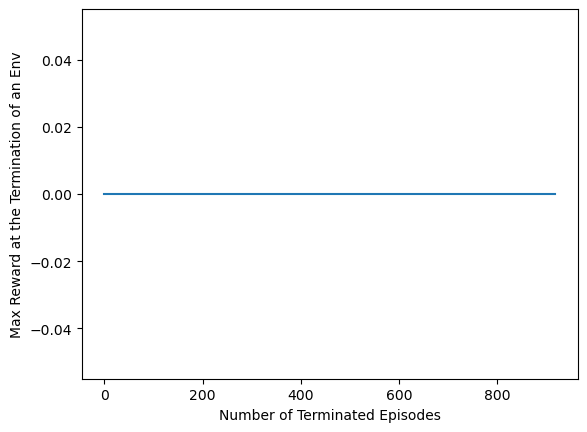

In [92]:

if not len(agent.all_returns)%agent.num_episodes_to_avg==0:
    all_returns_truncated = np.array(agent.all_returns[:-(len(agent.all_returns)%agent.num_episodes_to_avg)])
else:
    all_returns_truncated = np.array(agent.all_returns)
#all_returns_smoothed = np.average(all_returns_truncated.reshape(-1, agent.num_episodes_to_avg), axis=1)
print('mean reward:', np.mean(all_returns_truncated))
print('std reward:', np.std(all_returns_truncated))
print('max reward:', np.max(all_returns_truncated))
print('converge mean reward:', np.mean(all_returns_truncated[-1]))
plt.xlabel('Number of Terminated Episodes')
plt.ylabel('Max Reward at the Termination of an Env')
plt.plot(all_returns_truncated)
plt.show()

In [102]:
import imageio
class VideoRecorderRAM:
    def __init__(self, dir_name, fps=30):
        self.dir_name = dir_name
        self.fps = fps
        self.frames = []

    def reset(self):
        self.frames = []

    def record(self, frame):
        self.frames.append(frame)

    def save(self, file_name):
        path = os.path.join(self.dir_name, file_name)
        imageio.mimsave(path, self.frames, fps=self.fps, macro_block_size = None)

In [103]:
# virtualise one episode
env=make_env(env_name)
state, _ = env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated or steps > max_steps):
  # take action based on policy
  action = agent.policy(state)
  print(action)
  # environment receives the action and returns
  # next observation, reward, terminated, truncated and additional information if applicable
  state, reward, terminated, truncated, info = env.step(action)
  total_reward += reward
  steps += 1

print(f"Reward: {total_reward}")

# store RGB frames for the entire episode
frames = env.render()

#close the environment
env.close()

v= VideoRecorderRAM('BackgammonVids')
v.frames=frames
vfilename = f'PPO_Backgammon.mp4'
v.save(vfilename)


2
0
2
0
1
0
0
2
2
2
0
2
2
2
0
2
0
2
2
2
0
0
0
1
2
0
0
2
0
2
2
2
0
0
0
2
0
1
0
2
2
2
2
2
0
0
2
2
2
2
2
0
2
2
2
2
2
2
2
0
2
0
2
0
2
Reward: 0.0


Backgammon Results


---


Initial hyperparameters set using Schulman et al. (2017) Proximal Policy Optimisation Algorithms paper's parameter for Atari environments
Horizon - 128
Number of environments - 8
Learning Rate -
Batch size - 32
Discount - 0.99
GAE parameter (lambda) - 0.95
Clipping parameter - 0.1
Entropy coef - 0.01

In [ ]:
env_name = 'ALE/MsPacman-ram-v5'
n_envs = 8
gamma = 0.99
hidden_sizes = (64, 64, 64)
learning_rate = 0.00025
batch_size = 32
max_steps = 128
lam = 0.95
update_epochs = 2
clip_epsilon = 0.1
ent_coef = 0.01
max_grad_norm = 0.5
num_returns_to_avg = 3
num_episodes_to_avg = 5
total_timesteps = 100000

agent = PPOAgent(
    env_name = env_name,
    n_envs = n_envs,
    gamma = gamma,
    hidden_sizes = hidden_sizes,
    learning_rate = learning_rate,
    batch_size = batch_size,
    max_steps = max_steps,
    lam = lam,
    update_epochs = update_epochs,
    clip_epsilon = clip_epsilon,
    ent_coef = ent_coef,
    max_grad_norm = max_grad_norm,
    num_returns_to_avg = num_returns_to_avg,
    num_episodes_to_avg = num_episodes_to_avg,
    total_timesteps = total_timesteps
)


In [ ]:

agent.train()

In [ ]:

if not len(agent.all_returns)%agent.num_episodes_to_avg==0:
    all_returns_truncated = np.array(agent.all_returns[:-(len(agent.all_returns)%agent.num_episodes_to_avg)])
else:
    all_returns_truncated = np.array(agent.all_returns)
#all_returns_smoothed = np.average(all_returns_truncated.reshape(-1, agent.num_episodes_to_avg), axis=1)
print('mean reward:', np.mean(all_returns_truncated))
print('std reward:', np.std(all_returns_truncated))
print('max reward:', np.max(all_returns_truncated))
print('converge mean reward:', np.mean(all_returns_truncated[-1]))
plt.xlabel('Number of Terminated Episodes')
plt.ylabel('Max Reward at the Termination of an Env')
plt.plot(all_returns_truncated)
plt.show()

Increasing Trajectory Length

In [ ]:
env_name = 'ALE/MsPacman-ram-v5'
n_envs = 8
gamma = 0.99
hidden_sizes = (64, 64, 64)
learning_rate = 0.00025
batch_size = 32
max_steps = 256
lam = 0.95
update_epochs = 2
clip_epsilon = 0.1
ent_coef = 0.01
max_grad_norm = 0.5
num_returns_to_avg = 3
num_episodes_to_avg = 5
total_timesteps = 100000

agent = PPOAgent(
    env_name = env_name,
    n_envs = n_envs,
    gamma = gamma,
    hidden_sizes = hidden_sizes,
    learning_rate = learning_rate,
    batch_size = batch_size,
    max_steps = max_steps,
    lam = lam,
    update_epochs = update_epochs,
    clip_epsilon = clip_epsilon,
    ent_coef = ent_coef,
    max_grad_norm = max_grad_norm,
    num_returns_to_avg = num_returns_to_avg,
    num_episodes_to_avg = num_episodes_to_avg,
    total_timesteps = total_timesteps
)

In [ ]:

agent.train()

In [ ]:

if not len(agent.all_returns)%agent.num_episodes_to_avg==0:
    all_returns_truncated = np.array(agent.all_returns[:-(len(agent.all_returns)%agent.num_episodes_to_avg)])
else:
    all_returns_truncated = np.array(agent.all_returns)
#all_returns_smoothed = np.average(all_returns_truncated.reshape(-1, agent.num_episodes_to_avg), axis=1)
print('mean reward:', np.mean(all_returns_truncated))
print('std reward:', np.std(all_returns_truncated))
print('max reward:', np.max(all_returns_truncated))
print('converge mean reward:', np.mean(all_returns_truncated[-1]))
plt.xlabel('Number of Terminated Episodes')
plt.ylabel('Max Reward at the Termination of an Env')
plt.plot(all_returns_truncated)
plt.show()

In [ ]:
test_env = make_env(env_name, seed)
#test_env = gym.wrappers.RecordVideo(test_env, f"videos/{env_name}test")
max_ep_steps = 5000
#observation, _ = test_env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
observation, _ = test_env.reset()
observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32),dim=0)

while not (terminated or truncated):
    # take action based on policy
    with torch.no_grad():
      action, _, _, _ = agent.get_action_and_value(observation)
    action = action.cpu().item()

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    observation, reward, terminated, truncated, info = test_env.step(action)
    observation = torch.unsqueeze(torch.tensor(observation, dtype=torch.float32),dim=0)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = test_env.render()

# close the environment
test_env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))